### Machine Learning Emulation of Timeseries Antenatal Care Data 

In [1]:
"""
In this approach, i am using two timeseries prevalence from one timeseries prevalence data (One actual and other comprising only the first prevalence
in the run) to predict EIR. The create_sequences_with_initial_value achieves this
        """

'\nIn this approach, i am using two timeseries prevalence from one timeseries prevalence data (One actual and other comprising only the first prevalence\nin the run) to predict EIR. The create_sequences_with_initial_value achieves this\n        '

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import time
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [3]:
print(torch.__version__)

2.6.0+cu124


In [4]:
# Set seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)
random.seed(2)

In [5]:
print("Is CUDA available? ", torch.cuda.is_available())
print("GPU count: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

Is CUDA available?  True
GPU count:  8
GPU Name:  NVIDIA RTX A5000


### Data

In [6]:
#from src.preprocessing import process_dataframe

In [7]:
# Load and process data
df = pd.read_csv("data/sim_compendia_train/runs/ANC_Simulation_15000_runs_multi_init_eir.csv", index_col=0).reset_index(drop=True)
#df = df[(df['t'] >= 3650) & (df['t'] <= 7320)]
#df = process_dataframe(df)

### Exploratory Data Analysis

In [8]:
#from src.util import plot_subplots_for_runs

In [9]:
#plot_subplots_for_runs(df, num_runs=3)


In [10]:
#Cross Correlation
#from src.util import plot_cross_correlation

In [11]:
#plot_cross_correlation(df, 'EIR_true', ['incall'], single_target='incall')

## Preprocessing - Feature Engineering

In [12]:
train_data = df[df['run'] <= 14500]
eval_data = df[(df['run'] > 14500) & (df['run'] <= 14800)]
#test_data = df[(df['run'] > 980) & (df['run'] <= 1000)]
test_data = df[df['run'] > 14800]
cols_to_transform = ["EIR_true", "prev_true", "incall"]
log_transform = lambda x: np.log(x + 1e-8)  # Avoids log(0) errors

In [13]:
train_data_scaled = train_data.copy()
eval_data_scaled = eval_data.copy()
test_data_scaled = test_data.copy()
for col in cols_to_transform:
    train_data_scaled[col] = log_transform(train_data_scaled[col])
    eval_data_scaled[col] = log_transform(eval_data_scaled[col])
    test_data_scaled[col] = log_transform(test_data_scaled[col])

In [14]:
#from src.sequence_creator import create_sequences_with_avg_scalar

In [15]:
def create_sequences_with_separate_scalar(data, window_size):
    sequences = []
    scalars = []
    targets = []
    
    for run, run_df in data.groupby('run'):
        run_df = run_df.reset_index(drop=True)
        prev_true = run_df['prev_true'].to_numpy()

        for i in range(len(prev_true)):
            end_idx = i + window_size + 1

            if end_idx > len(prev_true):
                continue

            # Create the sequence with padding
            if i < window_size:
                pad_size = window_size - i
                pad_value = prev_true[0]
                pad_seq = np.full((pad_size,), pad_value)
                actual_seq = prev_true[0:end_idx]
                sequence = np.concatenate((pad_seq, actual_seq))
            else:
                sequence = prev_true[i - window_size:end_idx]

            sequence = sequence.reshape(-1, 1)

            # Calculate the scalar feature (24months average)
            if i >= 1:
                window_start = max(i - 24, 0)
                avg_prev = np.mean(prev_true[window_start:i])
            else:
                avg_prev = prev_true[0]

            # Append the results for this sample
            sequences.append(sequence.astype(np.float32))
            scalars.append(np.array([avg_prev], dtype=np.float32))
            targets.append(run_df.iloc[i][['EIR_true', 'incall']].values.astype(np.float32))

    x_seq = torch.tensor(np.array(sequences))      # (N, seq_len, 1)
    x_scalar = torch.tensor(np.array(scalars))     # (N, 1)
    y = torch.tensor(np.array(targets))            # (N, 2)

    return x_seq, x_scalar, y

In [16]:
class TwoInputDataset(torch.utils.data.Dataset):
    def __init__(self, x_seq, x_scalar, y):
        self.x_seq = x_seq
        self.x_scalar = x_scalar
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.x_seq[idx], self.x_scalar[idx]), self.y[idx]

In [17]:
#Specifying size inspired by cross-correlation
window_size = 10
#Creating sequences of tensors
start_time = time.time()
X_train_seq, X_train_scalar, y_train = create_sequences_with_separate_scalar(train_data_scaled, window_size)
X_eval_seq, X_eval_scalar, y_eval = create_sequences_with_separate_scalar(eval_data_scaled, window_size)
print(f"times taken to create_sequences is {time.time() - start_time:.2f} seconds")


times taken to create_sequences is 1657.75 seconds


In [18]:
train_dataset = TwoInputDataset(X_train_seq, X_train_scalar, y_train)
eval_dataset = TwoInputDataset(X_eval_seq, X_eval_scalar, y_eval)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [19]:
X_train_seq.shape

torch.Size([3393000, 21, 1])

In [20]:
X_train_seq[12]

tensor([[-1.4949],
        [-1.5110],
        [-1.5208],
        [-1.5428],
        [-1.5362],
        [-1.5373],
        [-1.5238],
        [-1.4850],
        [-1.4657],
        [-1.4530],
        [-1.4582],
        [-1.4488],
        [-1.4454],
        [-1.4341],
        [-1.4305],
        [-1.4269],
        [-1.4114],
        [-1.4038],
        [-1.4087],
        [-1.4047],
        [-1.4228]])

### Model Architecture and Training

In [21]:
#from src.model_exp import LSTMModel, train_model

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, architecture):
        super(LSTMModel, self).__init__()
        self.lstm_layers = nn.ModuleList()
        for i, hidden_size in enumerate(architecture):
            self.lstm_layers.append(
                nn.LSTM(
                    input_size if i == 0 else architecture[i - 1],
                    hidden_size,
                    batch_first=True
                )
            )
        self.fc = nn.Linear(architecture[-1] + 1, 2)  # output 2 values

    def forward(self, x_seq, x_scalar):
        x = x_seq
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        last_hidden = x[:, -1, :]  # (batch_size, hidden_size)
        combined = torch.cat((last_hidden, x_scalar), dim=1)  # (batch_size, hidden_size + 1)
        return self.fc(combined)  # (batch_size, 2)

In [23]:
def train_model(model, train_loader, eval_loader, model_name, epochs=20, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    # Track losses
    total_train_loss_history = []
    total_eval_loss_history = []
    eir_train_loss_history = []
    incall_train_loss_history = []
    eir_eval_loss_history = []
    incall_eval_loss_history = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        eir_loss_total = 0
        incall_loss_total = 0

        for (X_seq_batch, X_scalar_batch), y_batch in train_loader:
            X_seq_batch = X_seq_batch.to(device)
            X_scalar_batch = X_scalar_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_seq_batch, X_scalar_batch)

            # Separate losses
            y_pred_EIR = outputs[:, 0]
            y_pred_incall = outputs[:, 1]
            y_true_EIR = y_batch[:, 0]
            y_true_incall = y_batch[:, 1]

            loss_eir = mse(y_pred_EIR, y_true_EIR)
            loss_incall = mse(y_pred_incall, y_true_incall)
            loss = loss_eir + loss_incall

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            eir_loss_total += loss_eir.item()
            incall_loss_total += loss_incall.item()

        num_batches = len(train_loader)
        total_train_loss_history.append(total_loss / num_batches)
        eir_train_loss_history.append(eir_loss_total / num_batches)
        incall_train_loss_history.append(incall_loss_total / num_batches)

        # ----- Evaluation -----
        model.eval()
        eval_total = 0
        eval_eir_total = 0
        eval_incall_total = 0

        with torch.no_grad():
            for (X_val_seq, X_val_scalar), y_val in eval_loader:
                X_val_seq = X_val_seq.to(device)
                X_val_scalar = X_val_scalar.to(device)
                y_val = y_val.to(device)

                val_outputs = model(X_val_seq, X_val_scalar)

                y_pred_EIR = val_outputs[:, 0]
                y_pred_incall = val_outputs[:, 1]
                y_true_EIR = y_val[:, 0]
                y_true_incall = y_val[:, 1]

                val_loss_eir = mse(y_pred_EIR, y_true_EIR)
                val_loss_incall = mse(y_pred_incall, y_true_incall)
                val_loss = val_loss_eir + val_loss_incall

                eval_total += val_loss.item()
                eval_eir_total += val_loss_eir.item()
                eval_incall_total += val_loss_incall.item()

        num_eval_batches = len(eval_loader)
        total_eval_loss_history.append(eval_total / num_eval_batches)
        eir_eval_loss_history.append(eval_eir_total / num_eval_batches)
        incall_eval_loss_history.append(eval_incall_total / num_eval_batches)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_train_loss_history[-1]:.6f} "
              f"(EIR: {eir_train_loss_history[-1]:.6f}, Incall: {incall_train_loss_history[-1]:.6f}) | "
              f"Eval Loss: {total_eval_loss_history[-1]:.6f} "
              f"(EIR: {eir_eval_loss_history[-1]:.6f}, Incall: {incall_eval_loss_history[-1]:.6f})")

    duration = time.time() - start_time

    # Save the model
    model_path = f"Trial/{model_name}_model_15000runs_W10_trial_for_runs.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved as {model_path}")

    return (
        model,
        {
            "total_train": total_train_loss_history,
            "total_eval": total_eval_loss_history,
            "eir_train": eir_train_loss_history,
            "eir_eval": eir_eval_loss_history,
            "incall_train": incall_train_loss_history,
            "incall_eval": incall_eval_loss_history,
        },
        duration
    )

In [24]:
architectures = {
    #"2_layers": [128, 64],
    "3_layers": [200, 100, 50],
    "4_layers": [256, 128, 64, 32],
    #"5_layers": [300, 200, 100, 50, 25]
    #"6_layers": [512, 256, 128, 64, 32]
}

In [25]:
results = []

for name, architecture in architectures.items():
    print(f"\nTraining model: {name}")

    # Instantiate model with input_size=1 (for prev_true)
    model = LSTMModel(input_size=1, architecture=architecture)

    # Train model with new data structure
    trained_model, loss_dict, duration = train_model(
    model,
    train_loader,
    eval_loader,
    model_name=name
    )

    # Store results
    results.append({
    "name": name,
    "model": trained_model,
    "loss_history": loss_dict,
    "duration": duration
    })

print("\nTraining complete!")



Training model: 3_layers
Epoch 1/20 | Train Loss: 0.650861 (EIR: 0.210273, Incall: 0.440588) | Eval Loss: 0.291583 (EIR: 0.028247, Incall: 0.263336)
Epoch 2/20 | Train Loss: 0.295844 (EIR: 0.027758, Incall: 0.268086) | Eval Loss: 0.289248 (EIR: 0.027169, Incall: 0.262079)
Epoch 3/20 | Train Loss: 0.281004 (EIR: 0.024111, Incall: 0.256893) | Eval Loss: 0.276553 (EIR: 0.022718, Incall: 0.253836)
Epoch 4/20 | Train Loss: 0.271874 (EIR: 0.022290, Incall: 0.249584) | Eval Loss: 0.263454 (EIR: 0.018773, Incall: 0.244682)
Epoch 5/20 | Train Loss: 0.264379 (EIR: 0.020969, Incall: 0.243410) | Eval Loss: 0.258605 (EIR: 0.019130, Incall: 0.239475)
Epoch 6/20 | Train Loss: 0.257931 (EIR: 0.019992, Incall: 0.237939) | Eval Loss: 0.247622 (EIR: 0.018238, Incall: 0.229384)
Epoch 7/20 | Train Loss: 0.250942 (EIR: 0.018993, Incall: 0.231948) | Eval Loss: 0.242969 (EIR: 0.018643, Incall: 0.224326)
Epoch 8/20 | Train Loss: 0.245670 (EIR: 0.018281, Incall: 0.227389) | Eval Loss: 0.238869 (EIR: 0.016684, 

### Model Evaluation

In [26]:
#from src.util import plot_training_metrics

In [27]:
def plot_training_metrics(results):
    import matplotlib.pyplot as plt

    # Initialize separate plots for EIR and Incidence
    fig, (ax_eir, ax_incall) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    for result in results:
        name = result['name']
        loss_dict = result['loss_history']

        for loss_type, values in loss_dict.items():
            # Skip any 'total' loss types
            if 'total' in loss_type:
                continue

            label = f"{name} {loss_type.replace('_', ' ').title()}"

            # Route to the appropriate subplot
            if 'eir' in loss_type.lower():
                ax_eir.plot(values, label=label)
            elif 'incall' in loss_type.lower():
                ax_incall.plot(values, label=label)

    # Plot customization
    for ax, title in zip([ax_eir, ax_incall], ["EIR Loss Over Epochs", "Incall Loss Over Epochs"]):
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.set_yscale("log")
        ax.set_title(title)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.savefig("Trial/training_loss_dual_targets_15000run_for_runs.png")
    plt.show()


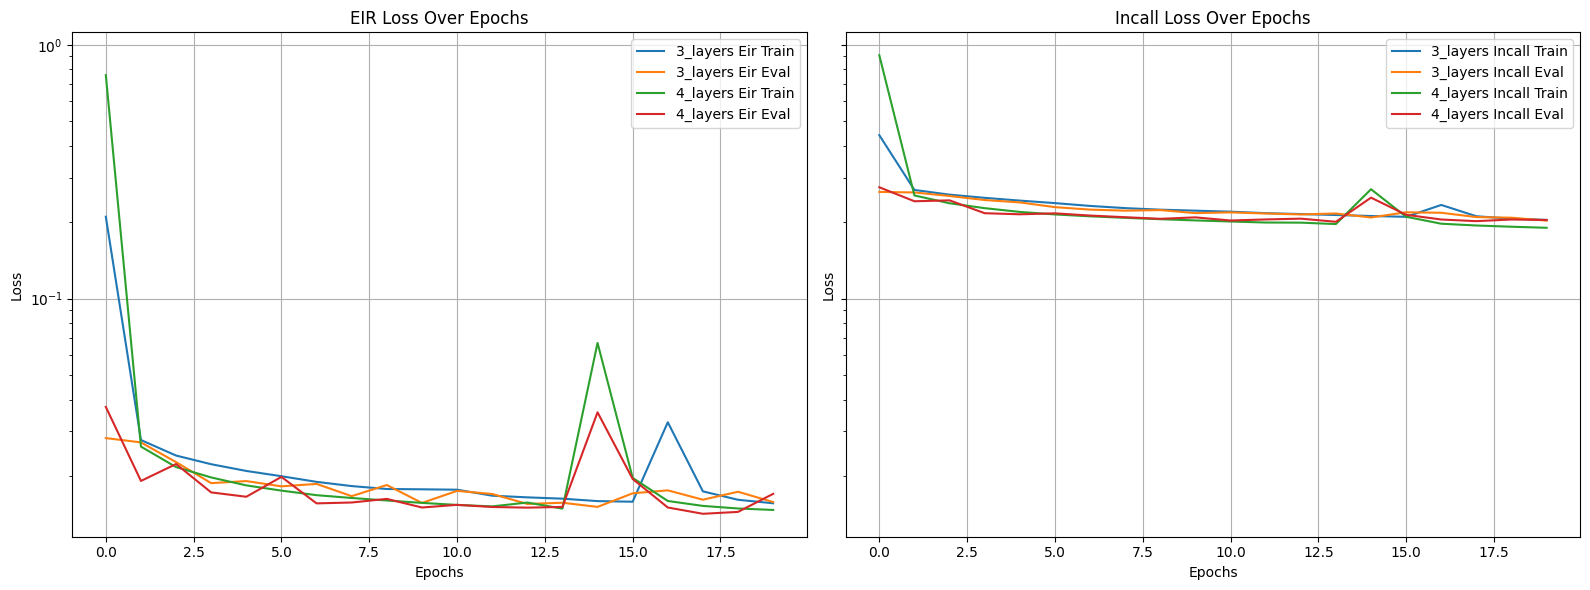

In [28]:
#Plot loss function
plot_training_metrics(results)

In [29]:
#from src.util import plot_model_comparison

In [30]:
#Function for comparing model parameters and training timelines 
def plot_model_comparison(results):
    model_names = [result['name'] for result in results]
    parameters = [sum(p.numel() for p in result['model'].parameters()) for result in results]
    durations = [result['duration'] for result in results]

    max_params = max(parameters)
    max_durations = max(durations) if max(durations) > 0 else 1

    normalized_params = [p / max_params for p in parameters]
    normalized_durations = [d / max_durations for d in durations]

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(model_names))
    bar_width = 0.4

    bar1 = ax.bar(x - bar_width / 2, normalized_params, bar_width, label="Normalized Parameters", color="skyblue")
    bar2 = ax.bar(x + bar_width / 2, normalized_durations, bar_width, label="Normalized Training Duration (sec)", color="darkorange")

    for bar, param in zip(bar1, parameters):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{param}', ha='center', va='bottom', fontsize=12, color="blue")
    for bar, duration in zip(bar2, durations):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{duration:.1f}', ha='center', va='bottom', fontsize=12, color="orange")

    ax.set_xlabel("Model")
    ax.set_ylabel("Normalized Values")
    ax.set_title("Comparison of Model Parameters and Training Durations")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, fontsize=10)
    ax.legend()

    plt.savefig("Trial/model_comparison_15000runs_trials_for_runs.png")
    plt.show()

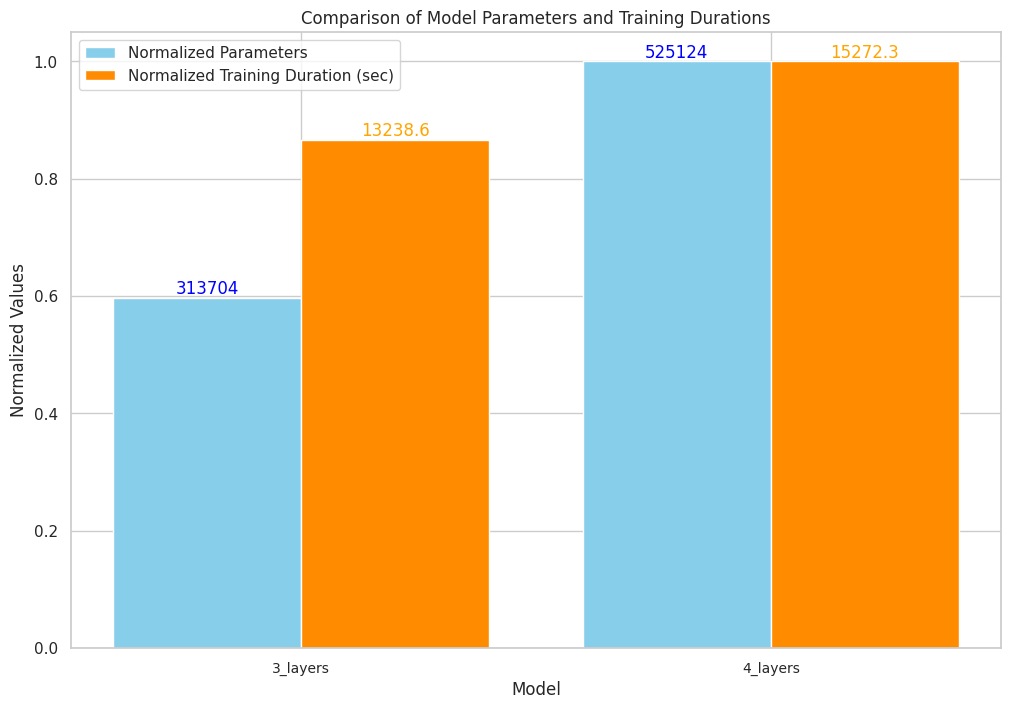

In [31]:
#Plot model parameters and training duration
plot_model_comparison(results)

### Model Evaluation and Inferencing

In [32]:
#from src.evaluate import predict_in_batches, plot_performance_metrics

In [33]:
#Process inferences in batches (avoiding GPU memory issue)
def predict_in_batches(model, X_seq, X_scalar, batch_size=512, device='cpu'):
    model.eval()
    preds_eir, preds_incall = [], []

    with torch.no_grad():
        for i in range(0, len(X_seq), batch_size):
            seq_batch = X_seq[i:i + batch_size].to(device)
            scalar_batch = X_scalar[i:i + batch_size].to(device)

            outputs = model(seq_batch, scalar_batch)  # shape: (batch_size, 2)
            outputs = outputs.cpu().numpy()

            preds_eir.append(outputs[:, 0:1])
            preds_incall.append(outputs[:, 1:2])

    return np.vstack(preds_eir), np.vstack(preds_incall)



#Function to Plot Evaluation Metrics
def plot_performance_metrics(results, X_train_seq, X_train_scalar, y_train, 
                             X_eval_seq, X_eval_scalar, y_eval):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    metrics_data = []

    for result in results:
        model = result['model']

        # Run batch prediction for both outputs
        y_train_pred_eir, y_train_pred_incall = predict_in_batches(model, X_train_seq, X_train_scalar, device=device)
        y_eval_pred_eir, y_eval_pred_incall = predict_in_batches(model, X_eval_seq, X_eval_scalar, device=device)

        # y_train and y_eval assumed to be shape: (N, 2) → [EIR_true, incall_true]
        y_train_eir, y_train_incall = y_train[:, 0].cpu().numpy(), y_train[:, 1].cpu().numpy()
        y_eval_eir, y_eval_incall = y_eval[:, 0].cpu().numpy(), y_eval[:, 1].cpu().numpy()

        # Metrics for both targets
        metrics_data.append({
            "Model": result['name'],
            "Train R² (EIR)": r2_score(y_train_eir, y_train_pred_eir),
            "Eval R² (EIR)": r2_score(y_eval_eir, y_eval_pred_eir),
            "Train R² (Incall)": r2_score(y_train_incall, y_train_pred_incall),
            "Eval R² (Incall)": r2_score(y_eval_incall, y_eval_pred_incall),

            "Train MSE (EIR)": mean_squared_error(y_train_eir, y_train_pred_eir),
            "Eval MSE (EIR)": mean_squared_error(y_eval_eir, y_eval_pred_eir),
            "Train MSE (Incall)": mean_squared_error(y_train_incall, y_train_pred_incall),
            "Eval MSE (Incall)": mean_squared_error(y_eval_incall, y_eval_pred_incall),

            "Train MAE (EIR)": mean_absolute_error(y_train_eir, y_train_pred_eir),
            "Eval MAE (EIR)": mean_absolute_error(y_eval_eir, y_eval_pred_eir),
            "Train MAE (Incall)": mean_absolute_error(y_train_incall, y_train_pred_incall),
            "Eval MAE (Incall)": mean_absolute_error(y_eval_incall, y_eval_pred_incall)
        })

    metrics_df = pd.DataFrame(metrics_data)
    sns.set_theme(style="whitegrid")

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # R²
    sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train R² (EIR)", "Eval R² (EIR)", "Train R² (Incall)", "Eval R² (Incall)"]), x="Model", y="value", hue="variable", ax=axes[0, 0], palette="viridis")
    axes[0, 0].set_title("R² Scores")
    axes[0, 0].set_ylabel("R² Score")

    # MSE
    sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train MSE (EIR)", "Eval MSE (EIR)", "Train MSE (Incall)", "Eval MSE (Incall)"]), x="Model", y="value", hue="variable", ax=axes[0, 1], palette="magma")
    axes[0, 1].set_title("Mean Squared Error (MSE)")
    axes[0, 1].set_ylabel("MSE")

    # MAE
    sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train MAE (EIR)", "Eval MAE (EIR)", "Train MAE (Incall)", "Eval MAE (Incall)"]), x="Model", y="value", hue="variable", ax=axes[1, 0], palette="cividis")
    axes[1, 0].set_title("Mean Absolute Error (MAE)")
    axes[1, 0].set_ylabel("MAE")

    # Optionally add another metric or leave blank
    axes[1, 1].axis("off")

    fig.tight_layout()
    plt.savefig("Trial/performance_metrics_dual_output_15000runs_for_runs.png")
    plt.show()

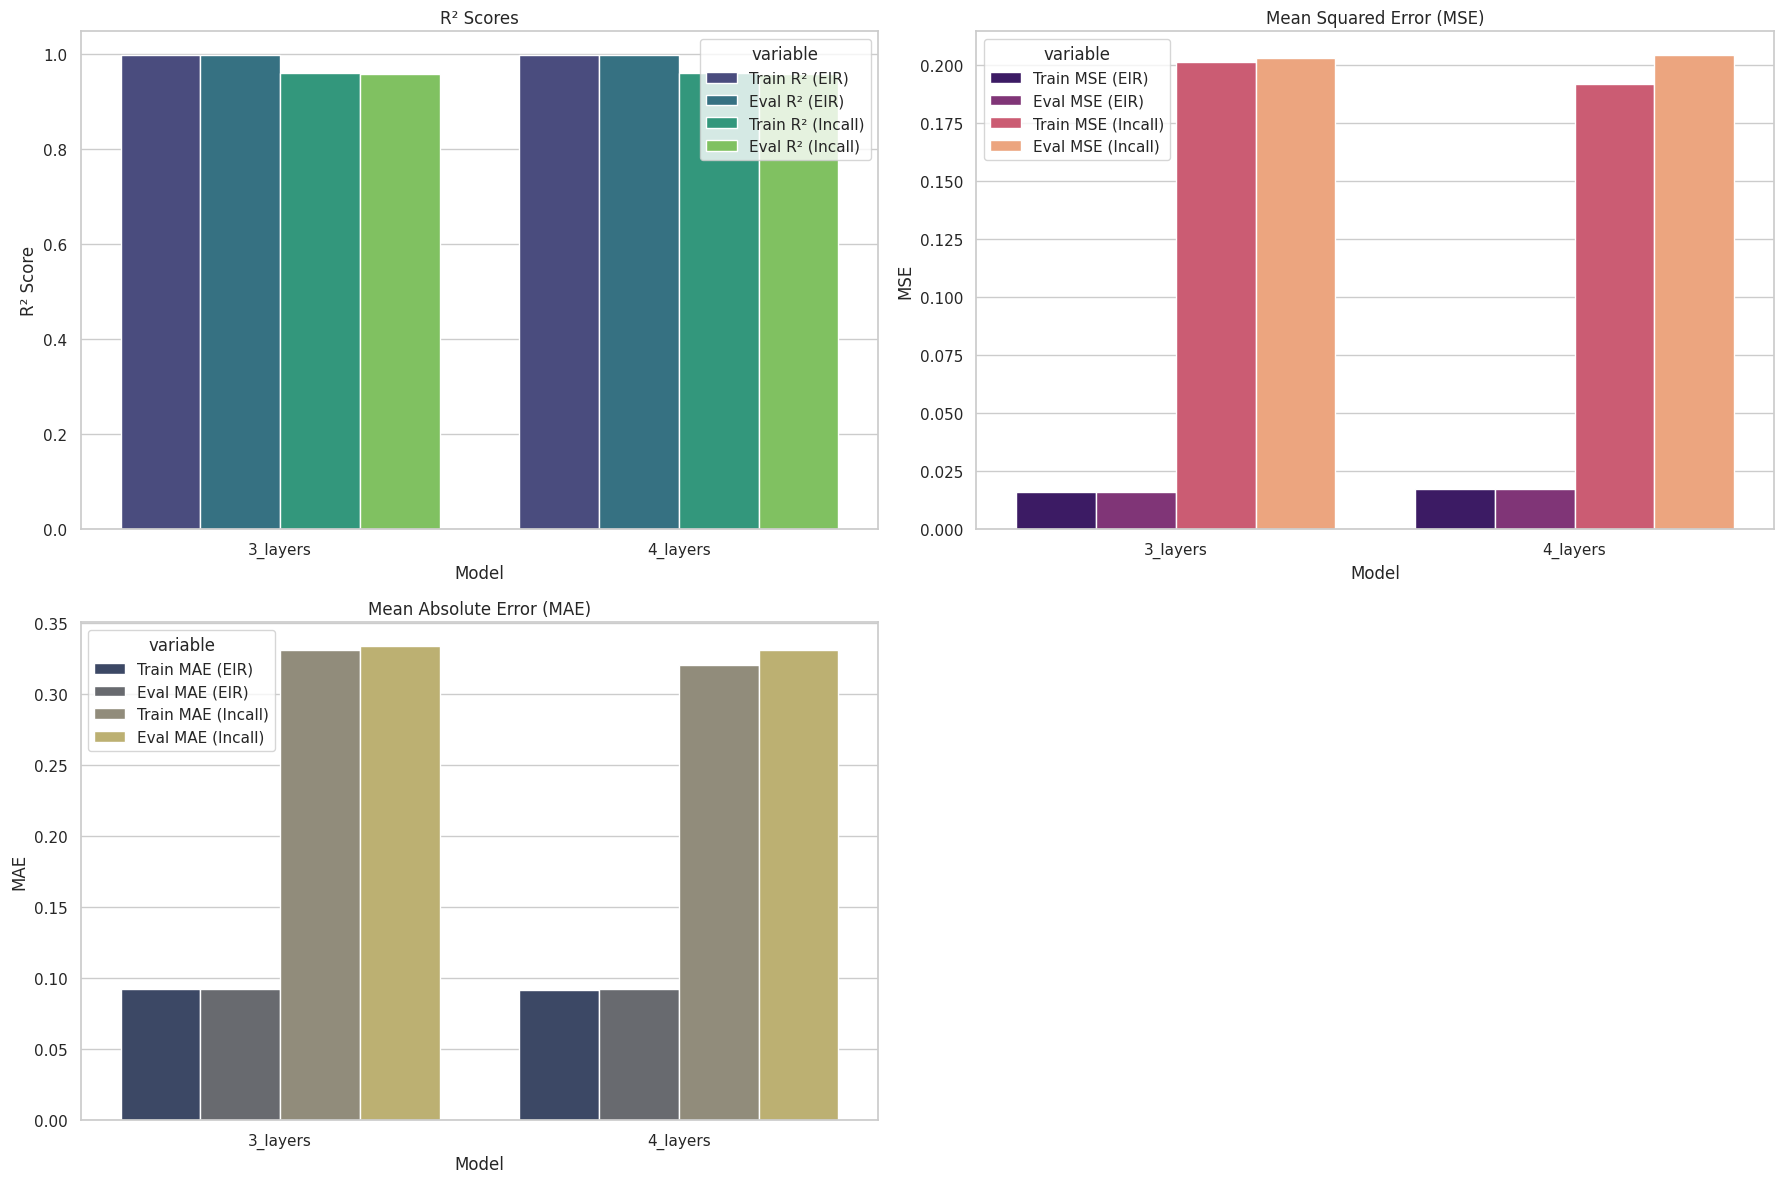

In [34]:
#Compare Model Performance across train models
plot_performance_metrics(results, X_train_seq, X_train_scalar, y_train, X_eval_seq, X_eval_scalar, y_eval)

### Inference on Test Set

In [35]:
#from src.inference import test_model, create_shifting_sequences

In [36]:
def test_model(model_path, test_data, window_size, num_runs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_size=1, architecture=[200, 100, 50])
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    log_transform = lambda x: np.log(x + 1e-8)
    inverse_log_transform = lambda x: np.exp(x) - 1e-8

    unique_runs = np.random.choice(test_data['run'].unique(), num_runs, replace=False)
    num_plots = len(unique_runs)
    num_cols = int(np.ceil(np.sqrt(num_plots)))
    num_rows = int(np.ceil(num_plots / num_cols))

    # Create subplot grids for EIR and Incidence
    fig_eir, axs_eir = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows), sharey='row')
    fig_inc, axs_inc = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows), sharey='row')

    axs_eir = axs_eir.flatten() if num_rows * num_cols > 1 else [axs_eir]
    axs_inc = axs_inc.flatten() if num_rows * num_cols > 1 else [axs_inc]

    handles_eir, labels_eir = [], []
    handles_inc, labels_inc = [], []

    for i, run in enumerate(unique_runs):
        run_data = test_data[test_data['run'] == run]
        scaled_run_data = run_data[['prev_true', 'EIR_true', 'incall']].apply(log_transform)

        # extract seq and scalar
        X_seq, X_scalar, y_test = create_sequences_with_separate_scalar(scaled_run_data, window_size)

        X_seq = X_seq.to(device)
        X_scalar = X_scalar.to(device)

        with torch.no_grad():
            outputs = model(X_seq, X_scalar)  # shape: (batch_size, 2)
            outputs = outputs.cpu().numpy()
            eir_pred = outputs[:, 0:1]  # shape: (batch_size, 1)
            inc_pred = outputs[:, 1:2]


        # Unscale all
        y_true = y_test.numpy()
        y_true_unscaled = inverse_log_transform(y_true)
        eir_pred_unscaled = inverse_log_transform(eir_pred)
        inc_pred_unscaled = inverse_log_transform(inc_pred)

        # Time axis
        time_column = run_data['t'].values[:len(y_true)]
        time_in_years = time_column / 365.25
        valid_indices = np.where(time_in_years >= 0)[0]

        time_in_years = time_in_years[valid_indices]
        y_true_unscaled = y_true_unscaled[valid_indices]
        eir_pred_unscaled = eir_pred_unscaled[valid_indices]
        inc_pred_unscaled = inc_pred_unscaled[valid_indices]
        y_true = y_true[valid_indices]

        # Compute metrics
        mse_eir = mean_squared_error(y_true[:, 0], eir_pred[valid_indices])
        mae_eir = mean_absolute_error(y_true[:, 0], eir_pred[valid_indices])
        r2_eir = r2_score(y_true[:, 0], eir_pred[valid_indices])

        mse_inc = mean_squared_error(y_true[:, 1], inc_pred[valid_indices])
        mae_inc = mean_absolute_error(y_true[:, 1], inc_pred[valid_indices])
        r2_inc = r2_score(y_true[:, 1], inc_pred[valid_indices])

        # Plotting EIR
        axs_eir[i].plot(time_in_years, y_true_unscaled[:, 0], label="True EIR", color="black", linestyle='-')
        axs_eir[i].plot(time_in_years, eir_pred_unscaled, label="Predicted EIR", color="#ff7f0e", linestyle='--')
        axs_eir[i].set_yscale('log')
        axs_eir[i].set_xlabel("Years")
        axs_eir[i].set_title(
            f'Run {run} | MSE: {mse_eir:.3f}, MAE: {mae_eir:.3f}, R²: {r2_eir:.3f}',
            fontsize=9, loc="left"
        )
        axs_eir[i].grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
        if i == 0:
            handles_eir, labels_eir = axs_eir[i].get_legend_handles_labels()

        # Plotting Incidence
        axs_inc[i].plot(time_in_years, y_true_unscaled[:, 1], label="True Incidence", color="black", linestyle='-')
        axs_inc[i].plot(time_in_years, inc_pred_unscaled, label="Predicted Incidence", color="#d62728", linestyle='--')
        axs_inc[i].set_yscale('log')
        axs_inc[i].set_xlabel("Years")
        axs_inc[i].set_title(
            f'Run {run} | MSE: {mse_inc:.3f}, MAE: {mae_inc:.3f}, R²: {r2_inc:.3f}',
            fontsize=9, loc="left"
        )
        axs_inc[i].grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
        if i == 0:
            handles_inc, labels_inc = axs_inc[i].get_legend_handles_labels()

    # Cleanup and final touches
    for j in range(num_plots, len(axs_eir)):
        fig_eir.delaxes(axs_eir[j])
        fig_inc.delaxes(axs_inc[j])

    fig_eir.suptitle("EIR_true Predictions", fontsize=16, fontweight="bold", y=0.96)
    fig_inc.suptitle("Incidence Predictions", fontsize=16, fontweight="bold", y=0.96)

    fig_eir.legend(handles_eir, labels_eir, loc='upper center', ncol=4)
    fig_inc.legend(handles_inc, labels_inc, loc='upper center', ncol=4)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig_eir.savefig("Trial/predicted_EIR_plot_15000runs_for_runs.png")
    fig_inc.savefig("Trial/predicted_Incidence_1500runs_for_runs.png")
    plt.show()

KeyError: 'run'

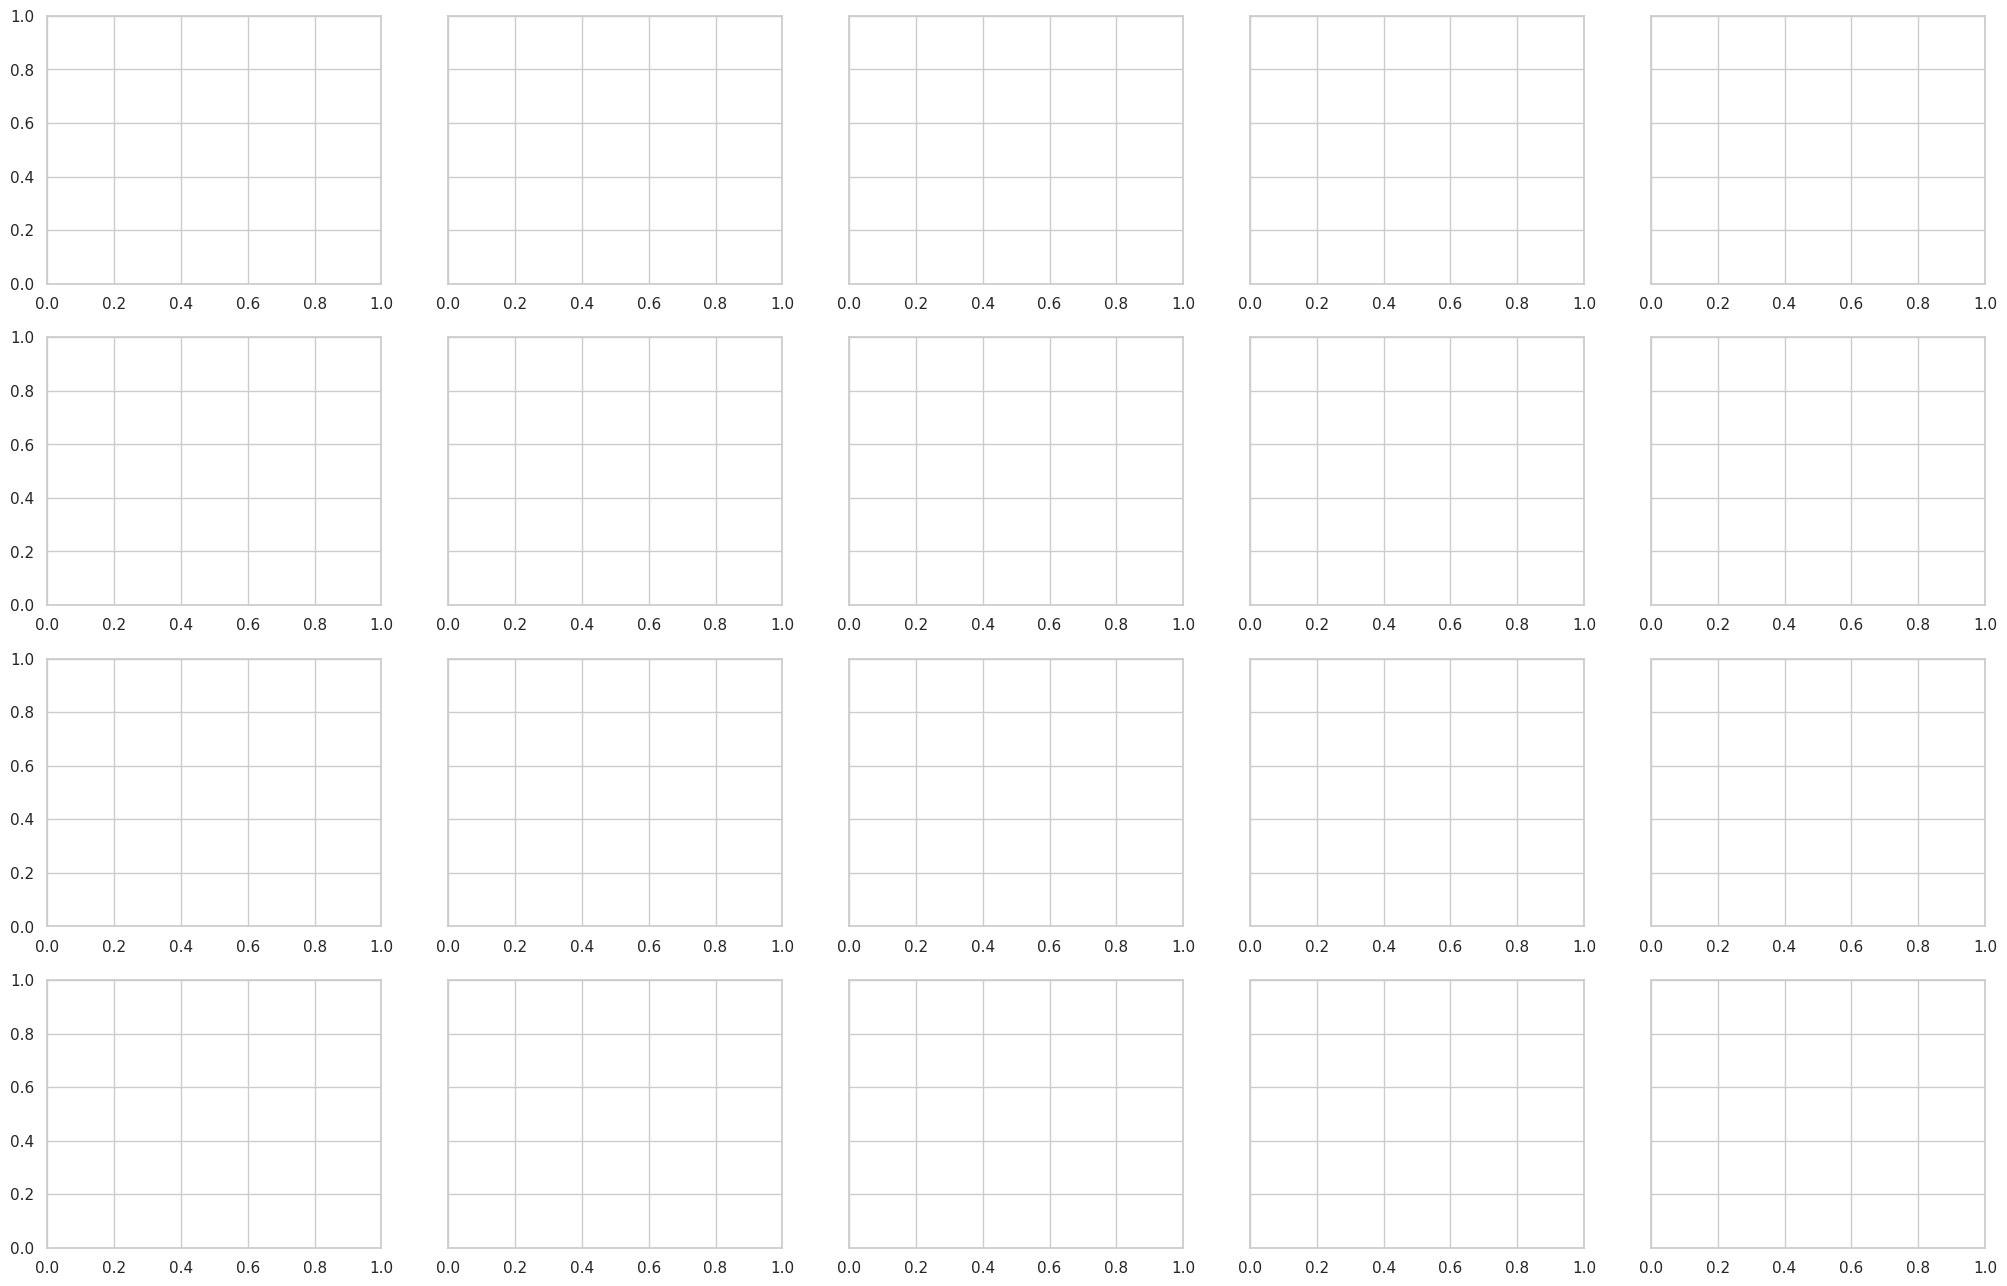

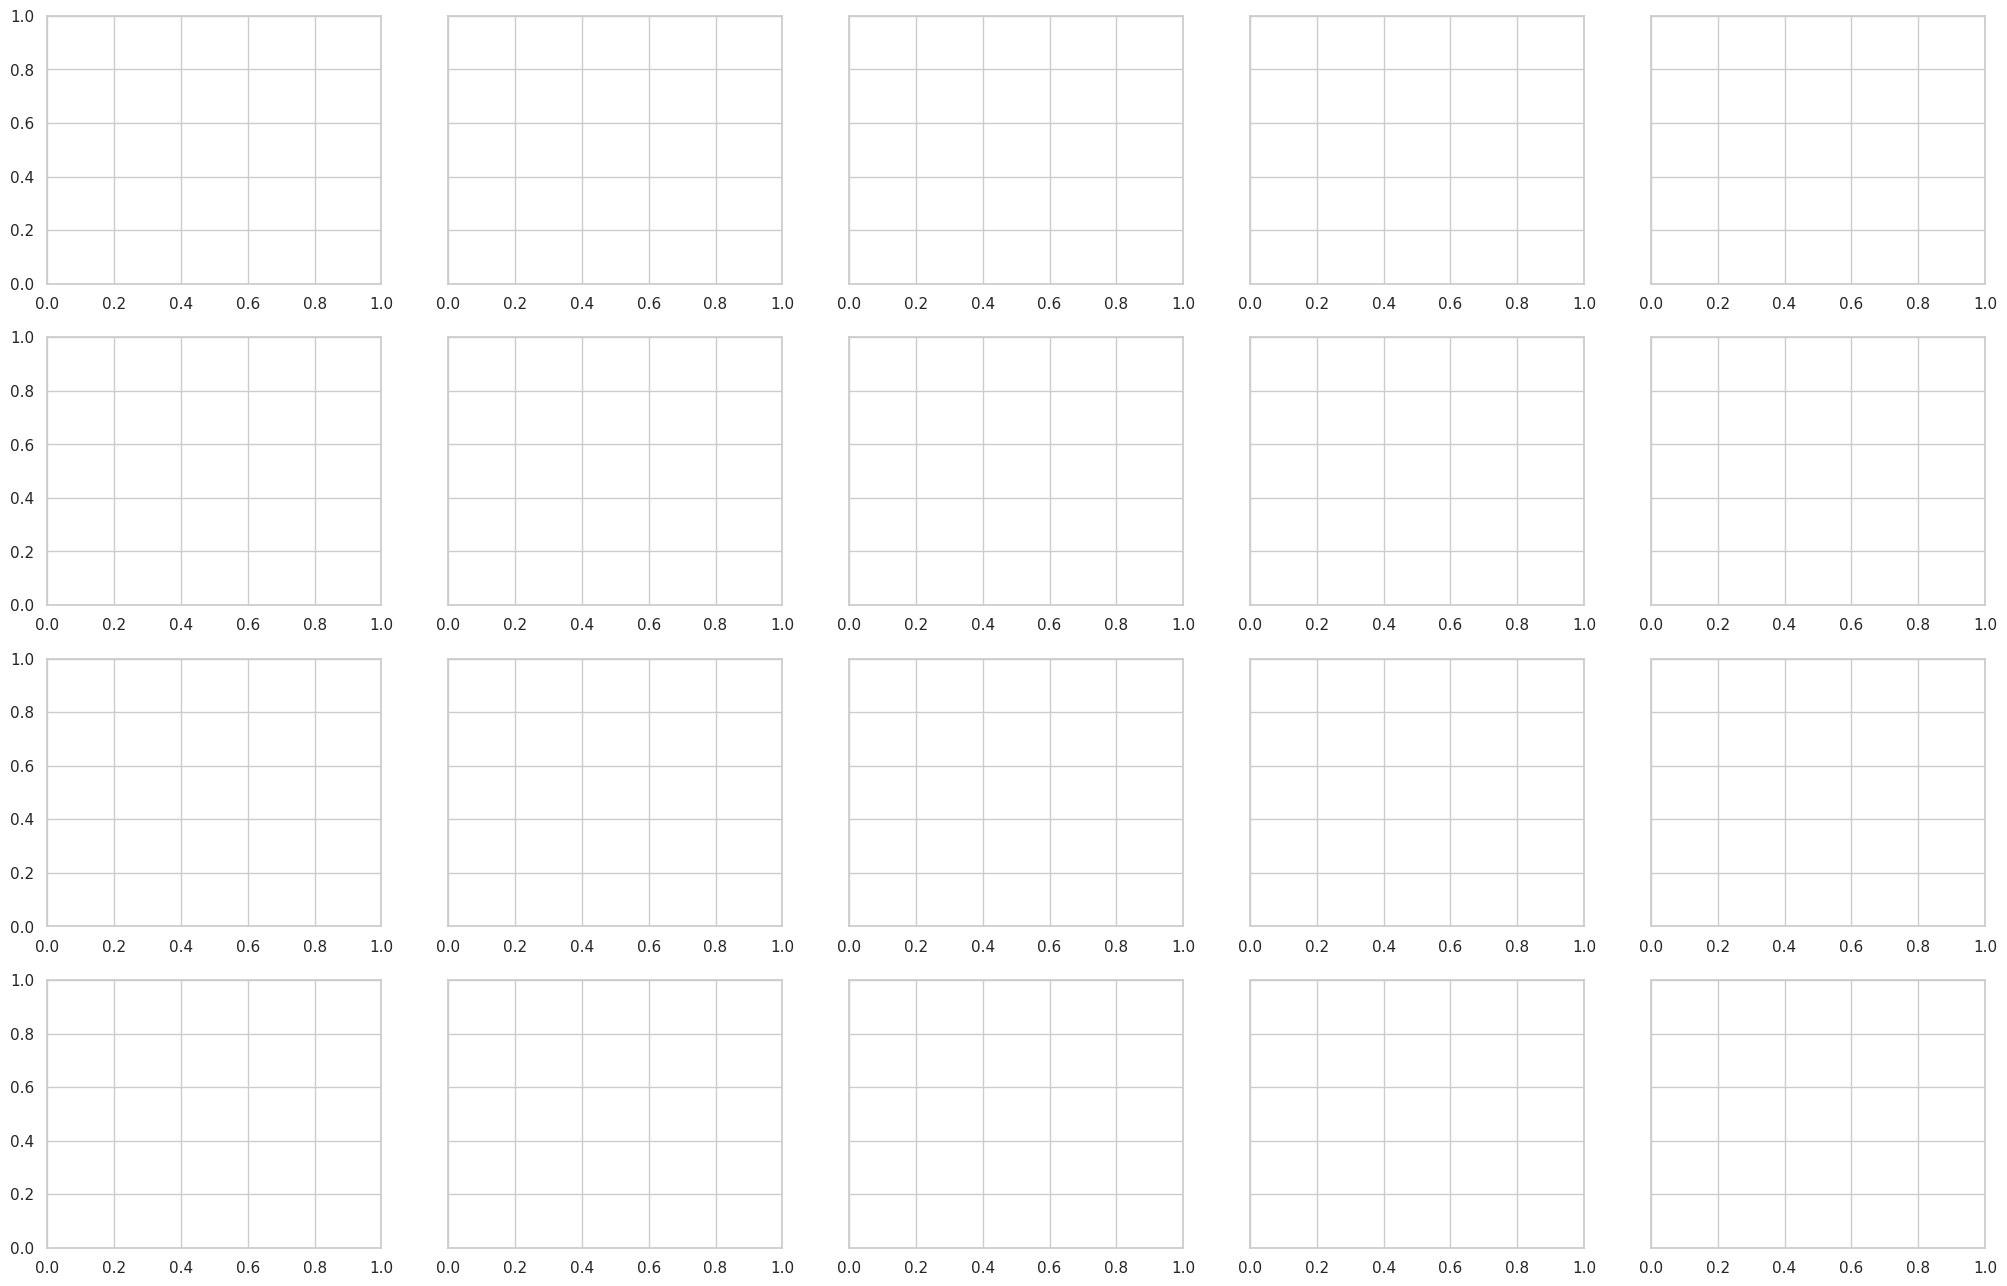

In [37]:
test_model("Trial/3_layers_model_15000runs_W10_trial_for_runs.pth", test_data, window_size=10, num_runs=20)

### Test Metrics Evaluation

In [ ]:
#from src.test import calculate_metrics, plot_performance_metrics

In [ ]:
# Define model architectures


# Model paths
model_paths = {
    "2_layers": "src/trained_model/shifting_sequences/2_layers_model_50000runs_W10.pth",
    "3_layers": "src/trained_model/shifting_sequences/3_layers_model_50000runs_W10.pth",
    "4_layers": "src/trained_model/shifting_sequences/4_layers_model_50000runs_W10.pth",
    "5_layers": "src/trained_model/shifting_sequences/5_layers_model_50000runs_W10.pth"
}


#  Ploting aggregated Test Metrics
plot_performance_metrics(test_data, window_size=10, model_paths=model_paths)

In [ ]:
test_dat = pd.read_csv("data/sim_compendia_test/ANC_Simulation_1000_test_runs.csv", index_col=0).reset_index(drop=True)

In [ ]:
test_model("src/trained_model/shifting_sequences/3_layers_model_50000runs_W10.pth", test_dat, window_size=10, num_runs=2)